In [48]:
import os
import shutil
import numpy as np
import h5py
import matplotlib.pyplot as plt
plt.rc('font', size=12.0)

import tensorflow as tf
from keras import layers, mixed_precision, regularizers
import keras_tuner as kt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [49]:
model = ['nl']
label = ['NL']
x_names = ['a', 'alpha', 'param_S', 'param_L', '', 'trans1', '', 'trans2', '']
for k in range(len(model)):
    if model[k] == 'mp' or model[k] == 'np':
        x_names[4], x_names[6], x_names[8] = 'exp1', 'exp2', 'exp3'
    else:
        x_names[4], x_names[6], x_names[8] = 'csq1', 'csq2', 'csq3'
y_names = [f"R_{i}" for i in range(100)]

dir = '/home/anik/bamr/out/aff_inv/'
mchain = h5py.File(dir + 'nl_all', 'r')['markov_chain_0']
x_ncols, y_ncols = len(x_names), len(y_names)
nrows, data = mchain['nlines'][0], mchain['data']
X, Y = np.zeros((x_ncols, nrows)), np.zeros((y_ncols, nrows))
for i in range(x_ncols):
    X[i] = data[x_names[i]]
for i in range(y_ncols):
    Y[i] = data[y_names[i]]
X, Y = X.T, Y.T

scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_Y = MinMaxScaler(feature_range=(0, 1))

x = scaler_X.fit_transform(X)

# Mask and scale only non-zero values in Y
nz = Y != 0
y = np.copy(Y)  # Copy Y to keep the structure with zeros intact
y[nz] = scaler_Y.fit_transform(Y[nz].reshape(-1, 1)).flatten()

x_tr, x_ts, y_tr, y_ts = train_test_split(x, y, test_size=0.2, random_state=42)
x_ts, x_vl, y_ts, y_vl = train_test_split(x_ts, y_ts, test_size=0.01, random_state=42)

tuner_dir = 'trials'

if os.path.exists(tuner_dir):
    shutil.rmtree(tuner_dir)

In [50]:
# Load model from file
#model = tf.keras.models.load_model("../../models/model_nl.keras")

def custom_loss(y_true, y_pred):
    mse_loss = tf.keras.losses.mean_squared_error(y_true, y_pred)
    # Penalty term for non-zero predictions where true value is near zero
    penalty = tf.reduce_mean(tf.where(tf.abs(y_true) < 1e-3, tf.square(y_pred), 0.0))
    penalty_weight = 0.01  # You may need to tune this weight based on your data
    return mse_loss + penalty_weight * penalty

model = tf.keras.models.Sequential([
    layers.Dense(320, activation='relu', input_shape=(x_ncols,)),
    layers.Dense(512, activation='relu'),
    layers.Dense(224, activation='relu'),
    layers.Dense(y_ncols, activation='softplus')
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

model.summary()

/home/anik/mconda/envs/tfg/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                │ (None, 320)            │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 512)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 224)            │       114,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 100)            │        22,500 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 304,964 (1.16 MB)

 Trainable params: 304,964 (1.16 MB)

 Non-trainable params: 0 (0.00 B)

In [51]:
batch_size = 128
num_epochs = 1000

# Set up a callback to stop early if given criteria is satisfied
stop_early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    min_delta=1.0e-6, 
    patience=10
)

In [52]:
training = model.fit(x=x_tr, y=y_tr, batch_size=batch_size, validation_data=(x_ts, y_ts), \
                    epochs=num_epochs, callbacks=[stop_early], verbose=2)

Epoch 1/1000
67/67 - 3s - 43ms/step - loss: 0.0433 - mae: 0.1374 - val_loss: 0.0035 - val_mae: 0.0459
Epoch 2/1000
67/67 - 0s - 1ms/step - loss: 0.0026 - mae: 0.0365 - val_loss: 0.0019 - val_mae: 0.0292
Epoch 3/1000
67/67 - 0s - 1ms/step - loss: 0.0016 - mae: 0.0256 - val_loss: 0.0014 - val_mae: 0.0222
Epoch 4/1000
67/67 - 0s - 1ms/step - loss: 0.0012 - mae: 0.0197 - val_loss: 0.0010 - val_mae: 0.0176
Epoch 5/1000
67/67 - 0s - 1ms/step - loss: 8.9229e-04 - mae: 0.0155 - val_loss: 7.9685e-04 - val_mae: 0.0142
Epoch 6/1000
67/67 - 0s - 1ms/step - loss: 7.1593e-04 - mae: 0.0130 - val_loss: 6.7073e-04 - val_mae: 0.0123
Epoch 7/1000
67/67 - 0s - 1ms/step - loss: 6.1932e-04 - mae: 0.0117 - val_loss: 6.0995e-04 - val_mae: 0.0118
Epoch 8/1000
67/67 - 0s - 1ms/step - loss: 5.5607e-04 - mae: 0.0111 - val_loss: 5.3418e-04 - val_mae: 0.0106
Epoch 9/1000
67/67 - 0s - 1ms/step - loss: 4.9674e-04 - mae: 0.0104 - val_loss: 4.9945e-04 - val_mae: 0.0103
Epoch 10/1000
67/67 - 0s - 1ms/step - loss: 4.5001

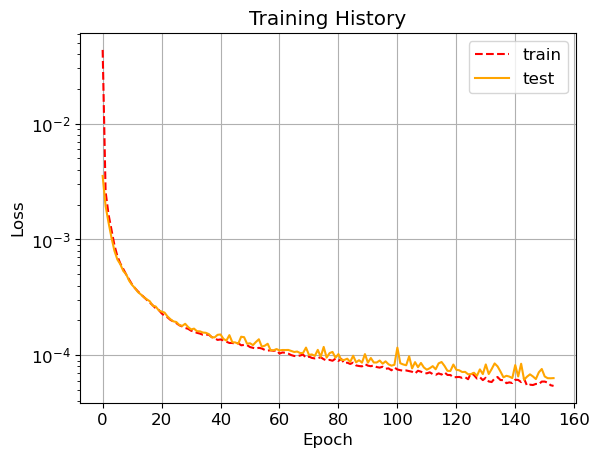

In [53]:
plt.semilogy(training.history['loss'], ls='--', color='red', label='train')
plt.semilogy(training.history['val_loss'], color='orange', label='test')
plt.grid()
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.title("Training History")
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


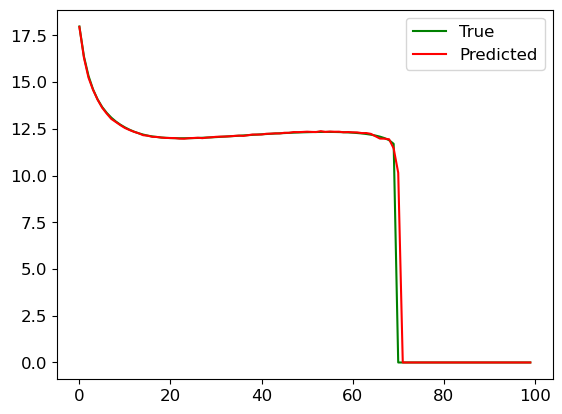

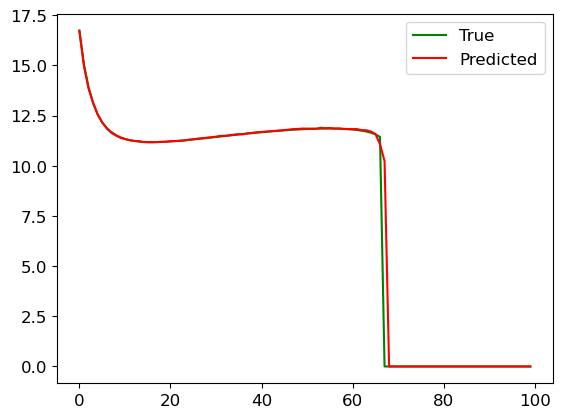

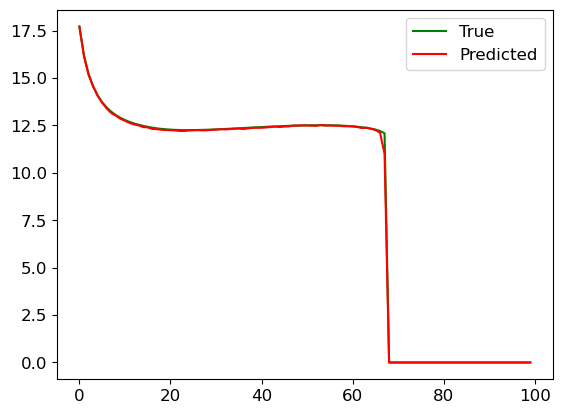

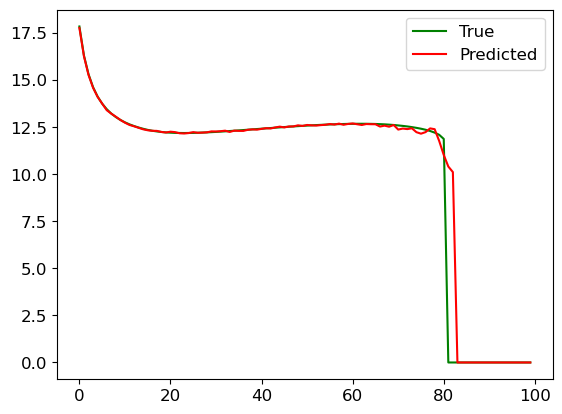

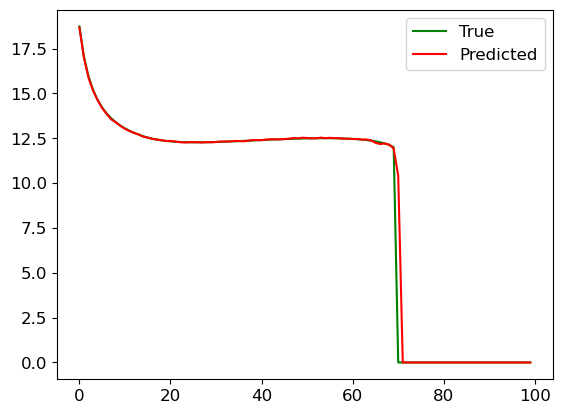

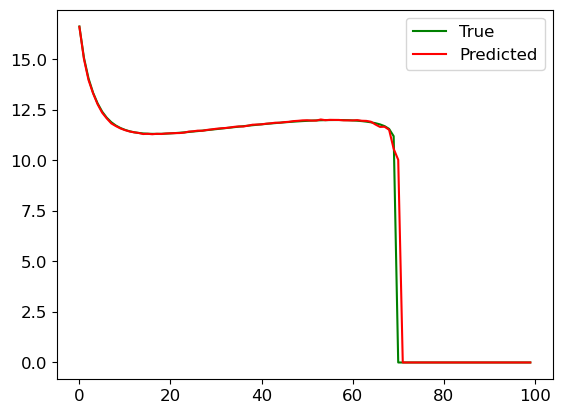

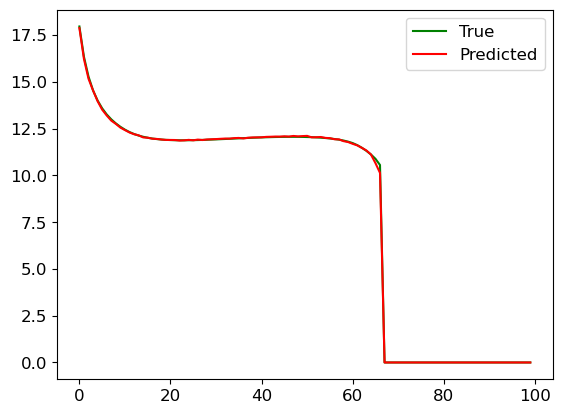

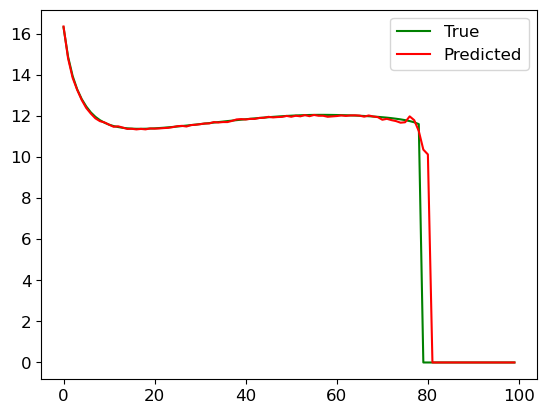

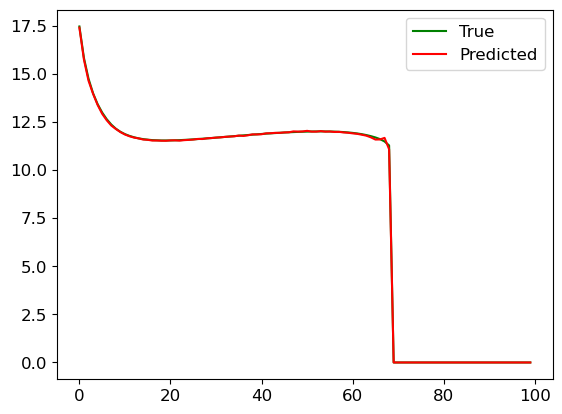

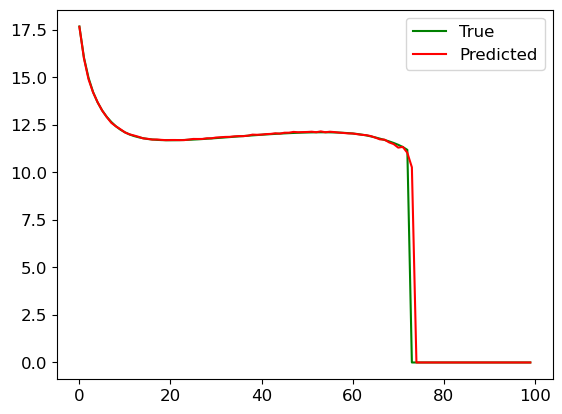

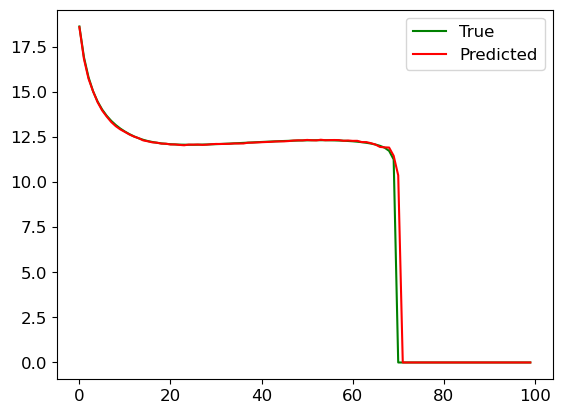

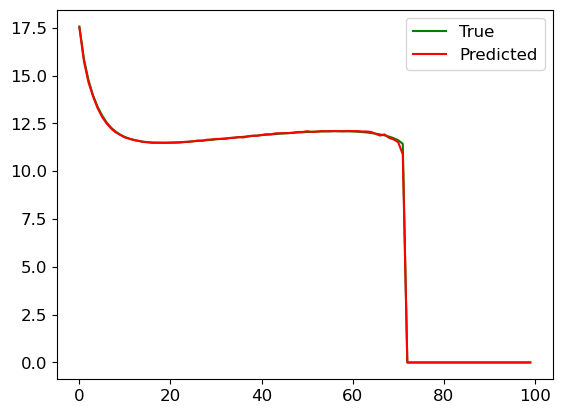

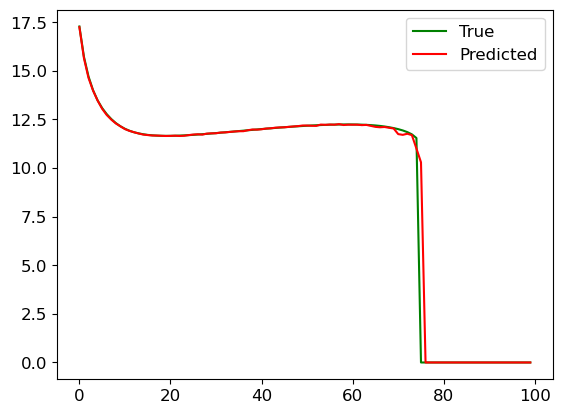

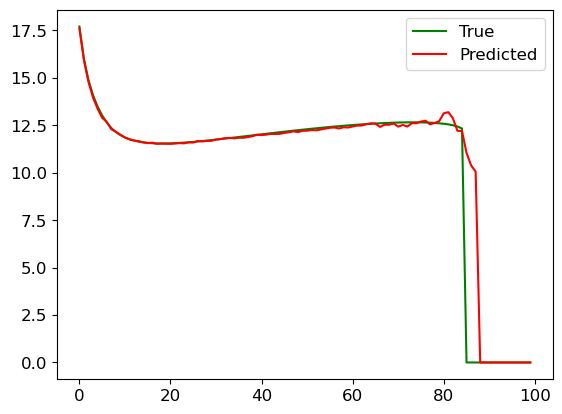

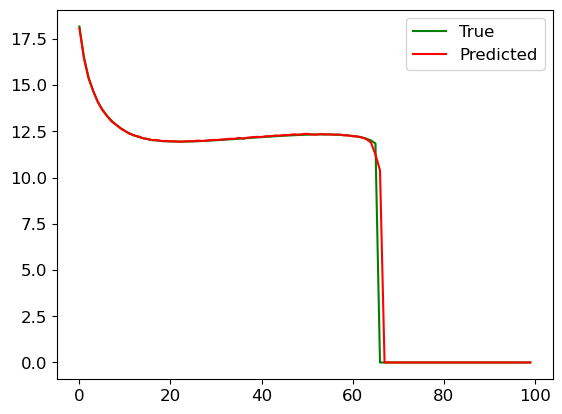

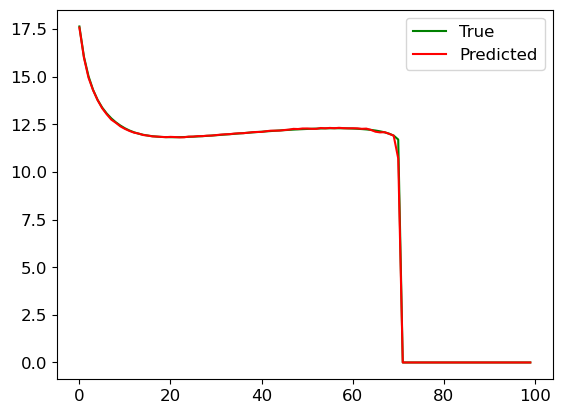

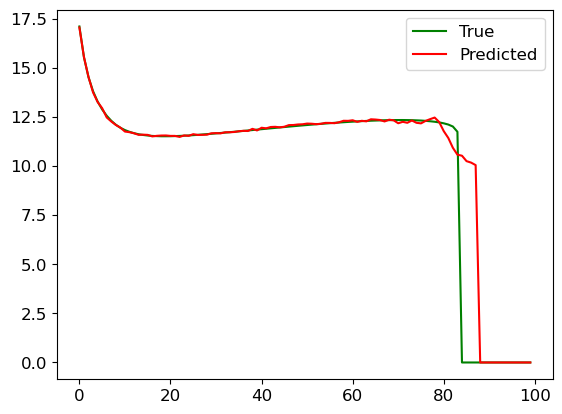

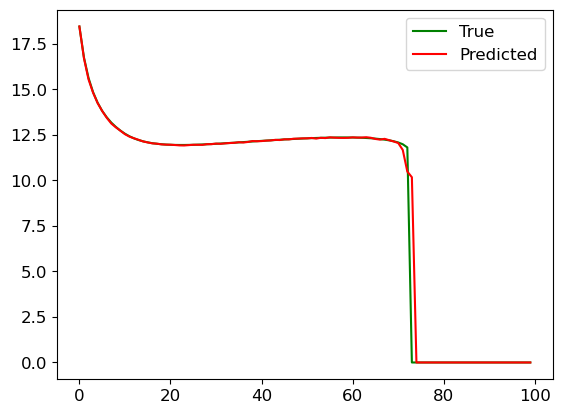

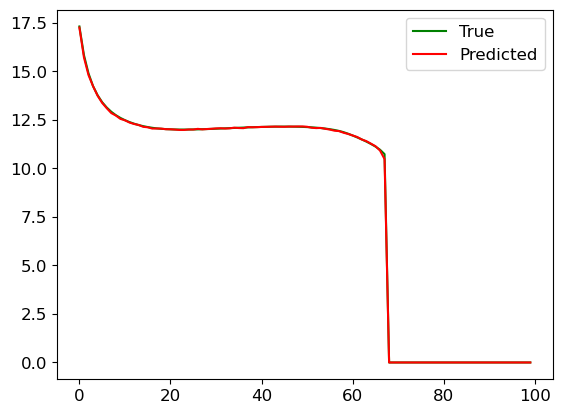

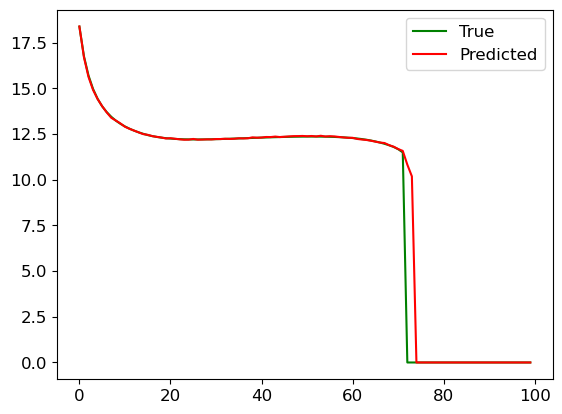

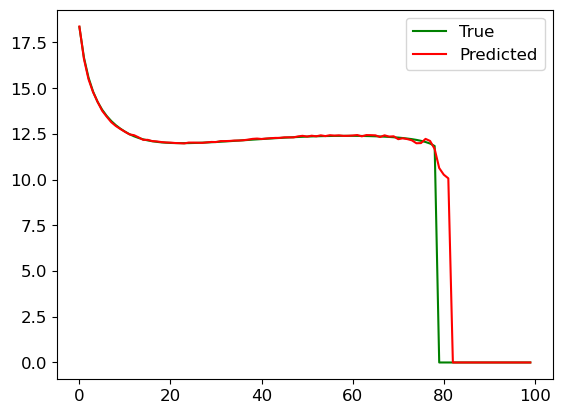

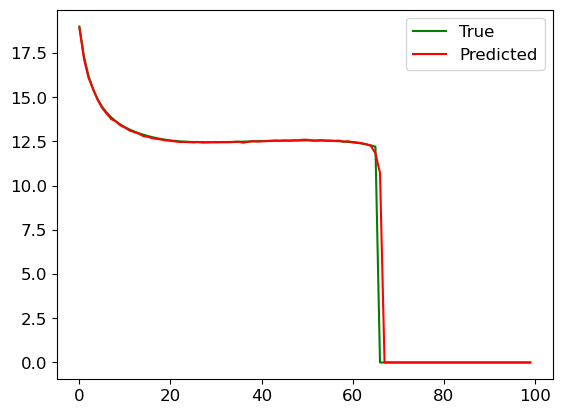

In [61]:
y_pr = model.predict(x_vl)

for i in range(y_pr.shape[0]):
    v = y_pr[i]
    v[v < 1e-2] = 0
    y_pr[i] = v

nz_pr = y_pr != 0
nz_vl = y_vl != 0

Y_pr = np.copy(y_pr)
Y_vl = np.copy(y_vl)

Y_pr[nz_pr] = scaler_Y.inverse_transform(y_pr[nz_pr].reshape(-1, 1)).flatten()
Y_vl[nz_vl] = scaler_Y.inverse_transform(y_vl[nz_vl].reshape(-1, 1)).flatten()

for i in range(y_pr.shape[0]):
    plt.plot(Y_vl[i], label='True', c='green')
    plt.plot(Y_pr[i], label='Predicted', c='red')
    plt.legend()
    plt.show()

In [66]:
Y_pr[0]

array([17.951897 , 16.304197 , 15.237537 , 14.58391  , 14.056648 ,
       13.628151 , 13.3151245, 13.031104 , 12.865422 , 12.695872 ,
       12.54493  , 12.436703 , 12.339602 , 12.2631445, 12.158962 ,
       12.133118 , 12.071602 , 12.066599 , 12.030772 , 12.012424 ,
       12.009009 , 12.003806 , 11.976664 , 11.970868 , 11.997997 ,
       12.009011 , 12.022962 , 12.001427 , 12.032203 , 12.047963 ,
       12.072796 , 12.082589 , 12.087221 , 12.101157 , 12.119425 ,
       12.136788 , 12.121107 , 12.1578865, 12.194989 , 12.192573 ,
       12.197093 , 12.234434 , 12.241062 , 12.25798  , 12.253245 ,
       12.288676 , 12.285261 , 12.326847 , 12.321918 , 12.332705 ,
       12.346864 , 12.334588 , 12.328338 , 12.374052 , 12.333649 ,
       12.355114 , 12.342121 , 12.346984 , 12.315312 , 12.328499 ,
       12.312277 , 12.3091545, 12.272031 , 12.274223 , 12.229828 ,
       12.102746 , 11.977756 , 11.973219 , 11.940938 , 11.453057 ,
       10.148251 ,  0.       ,  0.       ,  0.       ,  0.    

In [67]:
Y_vl[0]

array([17.97558649, 16.3712686 , 15.33264449, 14.6075385 , 14.07537144,
       13.66812799, 13.35506486, 13.10013502, 12.89237725, 12.72168669,
       12.57714101, 12.45364893, 12.34886028, 12.26255   , 12.19244667,
       12.13530258, 12.09482859, 12.06155494, 12.03541631, 12.01907251,
       12.00501557, 11.99946055, 11.99488851, 11.99634459, 11.9982546 ,
       12.0049679 , 12.0116812 , 12.02186013, 12.03235849, 12.04450762,
       12.05757759, 12.071088  , 12.08572398, 12.10035996, 12.11561866,
       12.13098609, 12.1463657 , 12.16176592, 12.17716615, 12.192072  ,
       12.20689887, 12.22134581, 12.23507027, 12.24879474, 12.26118303,
       12.27331724, 12.28468867, 12.29476333, 12.304838  , 12.31249043,
       12.32003086, 12.32570211, 12.33020951, 12.33339133, 12.33431685,
       12.33425483, 12.33095617, 12.32654902, 12.31825557, 12.30790716,
       12.29368937, 12.27506473, 12.25333342, 12.22330616, 12.18646496,
       12.14044318, 12.08105448, 12.00216503, 11.89265342, 11.69

In [68]:
y_pr[0]

array([0.8357511 , 0.66411936, 0.5530111 , 0.48492634, 0.4300043 ,
       0.38537005, 0.35276383, 0.323179  , 0.30592078, 0.28825974,
       0.2725369 , 0.26126346, 0.25114903, 0.24318492, 0.23233272,
       0.22964062, 0.22323295, 0.22271173, 0.2189799 , 0.21706869,
       0.21671306, 0.21617095, 0.21334367, 0.21274006, 0.21556589,
       0.21671312, 0.21816632, 0.21592313, 0.21912886, 0.22077057,
       0.22335728, 0.22437735, 0.22485994, 0.22631152, 0.22821435,
       0.23002295, 0.22838962, 0.23222075, 0.23608546, 0.23583372,
       0.23630458, 0.24019429, 0.24088459, 0.2426469 , 0.24215366,
       0.2458443 , 0.24548863, 0.24982043, 0.24930689, 0.25043058,
       0.25190538, 0.2506268 , 0.24997559, 0.25473744, 0.25052884,
       0.25276473, 0.25141138, 0.2519179 , 0.24861892, 0.24999245,
       0.24830265, 0.24797744, 0.24411052, 0.24433887, 0.2397145 ,
       0.22647701, 0.21345736, 0.21298483, 0.20962231, 0.15880251,
       0.02288791, 0.        , 0.        , 0.        , 0.     